In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

# import torch
from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

Using TensorFlow backend.


importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [6]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [3]:
indices = range(df.shape[0])

In [4]:
train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].tolist()
y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()

X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


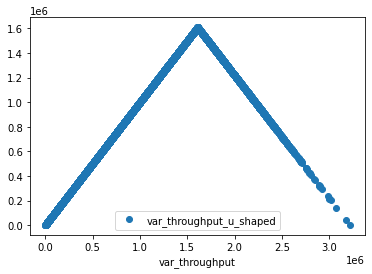

In [5]:
throughput_option = 'TP3'
worktime_option = 'WT2'
pc_agreement_option = 'PC2'
textlength_option = 'TL1'
special_option = 'SP1'
k_option_for_tp = 1

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [7]:
le = LabelEncoder()

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

C:\Users\lynne\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Individual Classifiers are LSTMS

In [8]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

# tok.fit_on_texts(X_test_col)
X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

In [9]:
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.00001)
def create_lstm():
    Inp = Input(name='inputs', shape=[max_len])
    x = Embedding(max_words, 50, input_length=max_len)(Inp)
    x = LSTM(64, name='LSTM_01')(x)
    x = Dropout(0.5, name='Dropout')(x)
    x = Dense(16, activation='relu',name='Dense_01')(x)
    out = Dense(1,activation='softmax', name='output')(x)
    model = Model(inputs=Inp, outputs=out)
    
    return model

### Construct individual LSTM models

In [10]:
# Rapport model
rapport_model = create_lstm()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
rapport_model.fit(X_train,y_train_rapport,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_rapport), callbacks=[early_stop])

Epoch 1/15


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node gradient_tape/functional_1/embedding_1/embedding_lookup/Reshape/_36}}]] [Op:__inference_train_function_3845]

Function call stack:
train_function


In [ ]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)
rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

In [19]:
# Game move model
gamemove_model = create_lstm()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
gamemove_model.fit(X_train,y_train_gamemove,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_gamemove), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 27ms/step - loss: 1.0298 - accuracy: 0.9325 - f1_m: 0.9635 - recall_m: 1.0000 - precision_m: 0.9300 - val_loss: 1.1601 - val_accuracy: 0.9239 - val_f1_m: 0.9603 - val_recall_m: 1.0000 - val_precision_m: 0.9240
Epoch 2/15
72/72 [==============================] - 2s 24ms/step - loss: 1.0298 - accuracy: 0.9325 - f1_m: 0.9635 - recall_m: 1.0000 - precision_m: 0.9300 - val_loss: 1.1601 - val_accuracy: 0.9239 - val_f1_m: 0.9603 - val_recall_m: 1.0000 - val_precision_m: 0.9240


In [20]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)
gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

In [22]:
# Reasoning model
reasoning_model = create_lstm()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
reasoning_model.fit(X_train,y_train_reasoning,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_reasoning), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 25ms/step - loss: 2.6064 - accuracy: 0.8291 - f1_m: 0.9057 - recall_m: 1.0000 - precision_m: 0.8280 - val_loss: 2.5952 - val_accuracy: 0.8298 - val_f1_m: 0.9069 - val_recall_m: 1.0000 - val_precision_m: 0.8303
Epoch 2/15
72/72 [==============================] - 2s 24ms/step - loss: 2.6064 - accuracy: 0.8291 - f1_m: 0.9074 - recall_m: 1.0000 - precision_m: 0.8314 - val_loss: 2.5952 - val_accuracy: 0.8298 - val_f1_m: 0.9069 - val_recall_m: 1.0000 - val_precision_m: 0.8303


In [23]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)
reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

In [25]:
# Share Information model
shareinfo_model = create_lstm()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
shareinfo_model.fit(X_train,y_train_share_information,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_share_information), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 25ms/step - loss: 2.4236 - accuracy: 0.8411 - f1_m: 0.9127 - recall_m: 1.0000 - precision_m: 0.8398 - val_loss: 2.4611 - val_accuracy: 0.8386 - val_f1_m: 0.9119 - val_recall_m: 1.0000 - val_precision_m: 0.8385
Epoch 2/15
72/72 [==============================] - 2s 23ms/step - loss: 2.4236 - accuracy: 0.8411 - f1_m: 0.9127 - recall_m: 1.0000 - precision_m: 0.8398 - val_loss: 2.4611 - val_accuracy: 0.8386 - val_f1_m: 0.9119 - val_recall_m: 1.0000 - val_precision_m: 0.8385


In [26]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)
shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

In [28]:
# Deception model
deception_model = create_lstm()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', f1_m, recall_m, precision_m])
deception_model.fit(X_train,y_train_deception,
          batch_size=128,
          epochs=15,
          validation_data=(X_test, y_test_deception), callbacks=[early_stop])

Epoch 1/15
72/72 [==============================] - 2s 25ms/step - loss: 0.7044 - accuracy: 0.9538 - f1_m: 0.9766 - recall_m: 1.0000 - precision_m: 0.9544 - val_loss: 0.9254 - val_accuracy: 0.9393 - val_f1_m: 0.9687 - val_recall_m: 1.0000 - val_precision_m: 0.9394
Epoch 2/15
72/72 [==============================] - 2s 22ms/step - loss: 0.7044 - accuracy: 0.9538 - f1_m: 0.9766 - recall_m: 1.0000 - precision_m: 0.9544 - val_loss: 0.9254 - val_accuracy: 0.9393 - val_f1_m: 0.9687 - val_recall_m: 1.0000 - val_precision_m: 0.9394


In [29]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.46965699208443273, 0.5, 0.48435374149659866, None)

### Joint Model by Keras Concatenate Layer

In [31]:
def create_concatenate_keras_model(models_arr):
    commonInput = Input(shape=[max_len])

    input_model_arr = []
    for model in models_arr: 
        outmodel = model(commonInput)
        input_model_arr.append(outmodel)
    
    mergedOut = Concatenate()(input_model_arr)

    mergedOut = Dense(32, activation='relu')(mergedOut)
#     mergedOut = Dropout(.5)(mergedOut)
#     mergedOut = Dense(32, activation='relu')(mergedOut)
#     mergedOut = Dropout(.35)(mergedOut)
    mergedOut = Dense(1, activation='softmax')(mergedOut)  #Cuz binary

    mergedModel = Model(commonInput, mergedOut)
    mergedModel.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy', f1_m, recall_m, precision_m])
    
    return mergedModel

In [ ]:
input_model_arr = []


list_models = [gamemove_model, reasoning_model, shareinfo_model, rapport_model]



for model in models_arr: 
    outmodel = model(commonInput)
    input_model_arr.append(outmodel)

commonInput = Input(shape=[max_len])
input_scalar = Input(shape=[max_len])
    
mergedOut = Concatenate()(input_model_arr)

mergedOut = Dense(32, activation='relu')(mergedOut)

mergedOut = Dense(1, activation='softmax')(mergedOut)  #Cuz binary

mergedModel = Model(commonInput, mergedOut)
mergedModel.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy', f1_m, recall_m, precision_m])

return mergedModel

In [32]:
print('Joint model by concatenate, predicting deception')
list_models = [gamemove_model, reasoning_model, shareinfo_model, rapport_model]
concat_list_models = []
for each_model in list_models:
    each_new_model = Model(each_model.inputs, each_model.layers[-2].output)
    concat_list_models.append(each_new_model)

merged_model = create_concatenate_keras_model(concat_list_models)
merged_model.summary()
merged_model.fit(X_train,y_train_deception,
          batch_size=128,
          epochs=15,
          validation_data=(X_test,y_test_deception), callbacks=[early_stop])

Joint model by concatenate, predicting deception
Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220)]        0                                            
__________________________________________________________________________________________________
functional_11 (Functional)      (None, 16)           80480       input_1[0][0]                    
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 16)           80480       input_1[0][0]                    
__________________________________________________________________________________________________
functional_15 (Functional)      (None, 16)           80480       input_1[0][0]                    
_____________________________________

In [34]:
joint_predict = merged_model.predict(X_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [35]:
0 in joint_predict

False

In [36]:
print('Joint model by concatenate, predicting rapport')
list_models = [gamemove_model, reasoning_model, shareinfo_model]
concat_list_models = []
for each_model in list_models:
    each_new_model = Model(each_model.inputs, each_model.layers[-2].output)
    concat_list_models.append(each_new_model)

merged_model = create_concatenate_keras_model(concat_list_models)
merged_model.summary()
merged_model.fit(X_train,y_train_rapport,
          batch_size=128,
          epochs=15,
          validation_data=(X_test,y_test_rapport), callbacks=[early_stop])

Joint model by concatenate, predicting rapport
Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 220)]        0                                            
__________________________________________________________________________________________________
functional_21 (Functional)      (None, 16)           80480       input_2[0][0]                    
__________________________________________________________________________________________________
functional_23 (Functional)      (None, 16)           80480       input_2[0][0]                    
__________________________________________________________________________________________________
functional_25 (Functional)      (None, 16)           80480       input_2[0][0]                    
_______________________________________

In [37]:
joint_predict = merged_model.predict(X_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append([np.argmax(a)])
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [38]:
0 in joint_predict

False